In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE


In [2]:
fraud_df = pd.read_csv("../data/Fraud_Data.csv")
ip_df = pd.read_csv("../data/IpAddress_to_Country.csv")
credit_df = pd.read_csv("../data/creditcard.csv")


In [5]:
fraud_df.isnull().sum()


user_id           0
signup_time       0
purchase_time     0
purchase_value    0
device_id         0
source            0
browser           0
sex               0
age               0
ip_address        0
class             0
dtype: int64

In [3]:
fraud_df.drop_duplicates(inplace=True)


In [7]:
fraud_df['signup_time'] = pd.to_datetime(fraud_df['signup_time'])
fraud_df['purchase_time'] = pd.to_datetime(fraud_df['purchase_time'])
fraud_df['ip_address'] = fraud_df['ip_address'].astype(int)


In [4]:
missing_summary = (
    fraud_df.isnull()
    .sum()
    .to_frame(name="Missing Count")
)

missing_summary["Missing Percentage (%)"] = (
    missing_summary["Missing Count"] / len(fraud_df)
) * 100

missing_summary


,Missing Count,Missing Percentage (%)
user_id,0,0.0
signup_time,0,0.0
purchase_time,0,0.0
purchase_value,0,0.0
device_id,0,0.0
source,0,0.0
browser,0,0.0
sex,0,0.0
age,0,0.0
ip_address,0,0.0


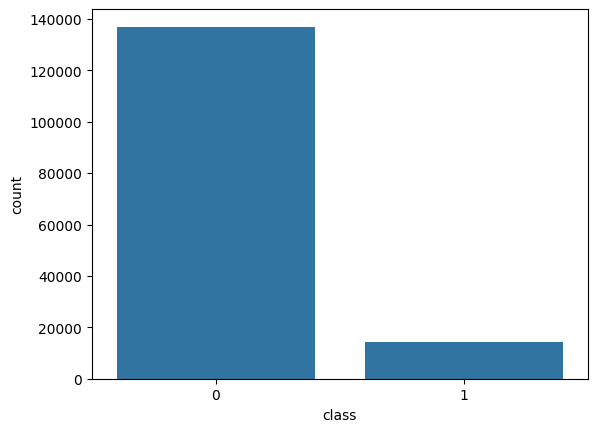

In [8]:
fraud_df['class'].value_counts(normalize=True)
sns.countplot(x='class', data=fraud_df)
plt.show()


<Axes: xlabel='class', ylabel='purchase_value'>

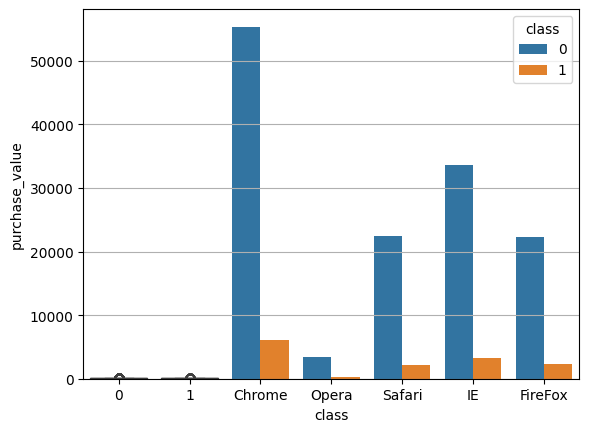

In [9]:
fraud_df['purchase_value'].hist(bins=50)
sns.boxplot(x='class', y='purchase_value', data=fraud_df)
sns.countplot(x='browser', hue='class', data=fraud_df)


In [10]:
ip_df['lower_bound_ip_address'] = ip_df['lower_bound_ip_address'].astype(int)
ip_df['upper_bound_ip_address'] = ip_df['upper_bound_ip_address'].astype(int)
def get_country(ip):
    row = ip_df[(ip_df['lower_bound_ip_address'] <= ip) &
                (ip_df['upper_bound_ip_address'] >= ip)]
    return row['country'].values[0] if len(row) > 0 else 'Unknown'

fraud_df['country'] = fraud_df['ip_address'].apply(get_country)


In [11]:
fraud_df['hour_of_day'] = fraud_df['purchase_time'].dt.hour
fraud_df['day_of_week'] = fraud_df['purchase_time'].dt.dayofweek
fraud_df['time_since_signup'] = (fraud_df['purchase_time'] - fraud_df['signup_time']).dt.total_seconds()
fraud_df['transaction_count'] = fraud_df.groupby('user_id')['user_id'].transform('count')


In [12]:
fraud_df = pd.get_dummies(fraud_df, columns=['browser', 'source', 'sex', 'country'], drop_first=True)


In [13]:
scaler = StandardScaler()
fraud_df[['purchase_value', 'time_since_signup']] = scaler.fit_transform(fraud_df[['purchase_value', 'time_since_signup']])


In [14]:
X = fraud_df.drop(columns=['class'])
y = fraud_df['class']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)


In [18]:
X_train['signup_time'] = X_train['signup_time'].astype('int64') // 10**9
X_train['purchase_time'] = X_train['purchase_time'].astype('int64') // 10**9
X_train = pd.get_dummies(X_train, drop_first=True)


In [22]:
from sklearn.preprocessing import StandardScaler

num_cols = ['purchase_value', 'time_since_signup', 'transaction_count', 'hour_of_day', 'day_of_week']
scaler = StandardScaler()
X_train[num_cols] = scaler.fit_transform(X_train[num_cols])
X_test[num_cols] = scaler.transform(X_test[num_cols])


In [24]:
X = fraud_df.drop(columns=['user_id', 'device_id'])
y = fraud_df['class']


In [25]:
# Convert to datetime
X['signup_time'] = pd.to_datetime(X['signup_time'])
X['purchase_time'] = pd.to_datetime(X['purchase_time'])

# Create features
X['time_since_signup'] = (X['purchase_time'] - X['signup_time']).dt.total_seconds()
X['hour_of_day'] = X['purchase_time'].dt.hour
X['day_of_week'] = X['purchase_time'].dt.dayofweek

# Drop original timestamp columns
X = X.drop(columns=['signup_time', 'purchase_time'])


In [29]:
X.columns = X.columns.str.strip()

categorical_cols = ['source', 'browser', 'sex']
for col in categorical_cols:
    if col in X.columns:
        freq = X[col].value_counts() / len(X)
        X[col] = X[col].map(freq)
    else:
        print(f"Column {col} not found")


Column source not found
Column browser not found
Column sex not found


In [30]:
print(fraud_df.columns.tolist())


['user_id', 'signup_time', 'purchase_time', 'purchase_value', 'device_id', 'age', 'ip_address', 'class', 'hour_of_day', 'day_of_week', 'time_since_signup', 'transaction_count', 'browser_FireFox', 'browser_IE', 'browser_Opera', 'browser_Safari', 'source_Direct', 'source_SEO', 'sex_M', 'country_Albania', 'country_Algeria', 'country_Angola', 'country_Antigua and Barbuda', 'country_Argentina', 'country_Armenia', 'country_Australia', 'country_Austria', 'country_Azerbaijan', 'country_Bahamas', 'country_Bahrain', 'country_Bangladesh', 'country_Barbados', 'country_Belarus', 'country_Belgium', 'country_Belize', 'country_Benin', 'country_Bermuda', 'country_Bhutan', 'country_Bolivia', 'country_Bonaire; Sint Eustatius; Saba', 'country_Bosnia and Herzegowina', 'country_Botswana', 'country_Brazil', 'country_British Indian Ocean Territory', 'country_Brunei Darussalam', 'country_Bulgaria', 'country_Burkina Faso', 'country_Burundi', 'country_Cambodia', 'country_Cameroon', 'country_Canada', 'country_Cap

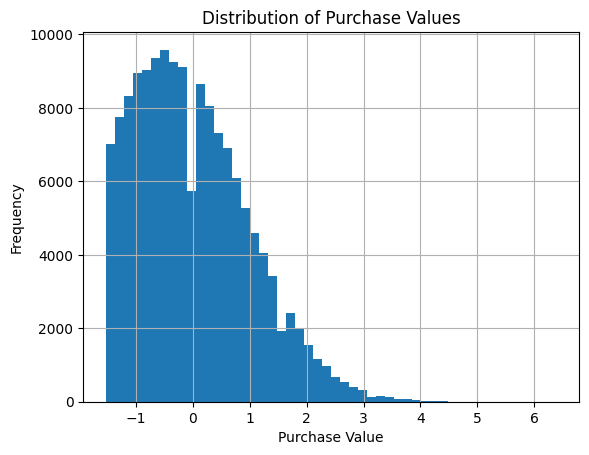

In [39]:
plt.figure()
fraud_df['purchase_value'].hist(bins=50)
plt.title("Distribution of Purchase Values")
plt.xlabel("Purchase Value")
plt.ylabel("Frequency")
plt.show()


<Figure size 640x480 with 0 Axes>

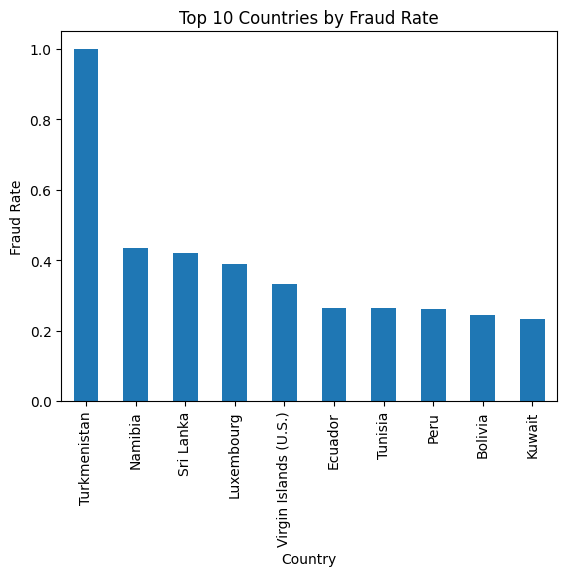

In [40]:
import pandas as pd

country_cols = [c for c in fraud_df.columns if c.startswith("country_")]

country_fraud_rates = {}

for col in country_cols:
    country_name = col.replace("country_", "")
    fraud_rate = fraud_df.loc[fraud_df[col] == 1, 'class'].mean()
    country_fraud_rates[country_name] = fraud_rate

country_df = pd.DataFrame.from_dict(
    country_fraud_rates,
    orient='index',
    columns=['Fraud Rate']
).dropna()

top_countries = country_df.sort_values(
    by='Fraud Rate',
    ascending=False
).head(10)

plt.figure()
top_countries.plot(kind='bar')
plt.title("Top 10 Countries by Fraud Rate")
plt.xlabel("Country")
plt.ylabel("Fraud Rate")
plt.legend().remove()
plt.show()


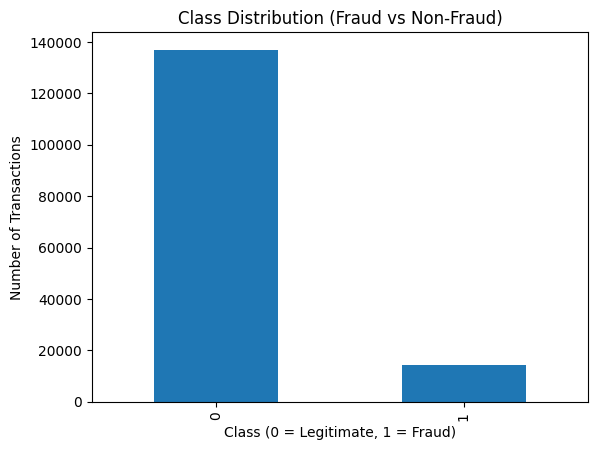

In [38]:
import matplotlib.pyplot as plt

class_counts = fraud_df['class'].value_counts()

plt.figure()
class_counts.plot(kind='bar')
plt.title("Class Distribution (Fraud vs Non-Fraud)")
plt.xlabel("Class (0 = Legitimate, 1 = Fraud)")
plt.ylabel("Number of Transactions")
plt.show()


In [31]:
X = fraud_df.drop(columns=[
    'class',
    'user_id',
    'device_id',
    'signup_time',
    'purchase_time',
    'ip_address'
])

y = fraud_df['class']


In [32]:
# Get country columns
country_cols = [c for c in X.columns if c.startswith('country_')]

# Create single country risk score
country_risk = (
    fraud_df[country_cols]
    .multiply(fraud_df['class'], axis=0)
    .sum() / fraud_df[country_cols].sum()
)

# Map risk score
X['country_risk'] = fraud_df[country_cols].idxmax(axis=1).map(
    lambda c: country_risk.get(c, 0)
)

# Drop all country dummy columns
X.drop(columns=country_cols, inplace=True)


In [33]:
from sklearn.preprocessing import StandardScaler

num_cols = [
    'purchase_value',
    'age',
    'time_since_signup',
    'transaction_count',
    'hour_of_day',
    'day_of_week',
    'country_risk'
]

scaler = StandardScaler()
X[num_cols] = scaler.fit_transform(X[num_cols])


In [34]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    stratify=y,
    random_state=42
)


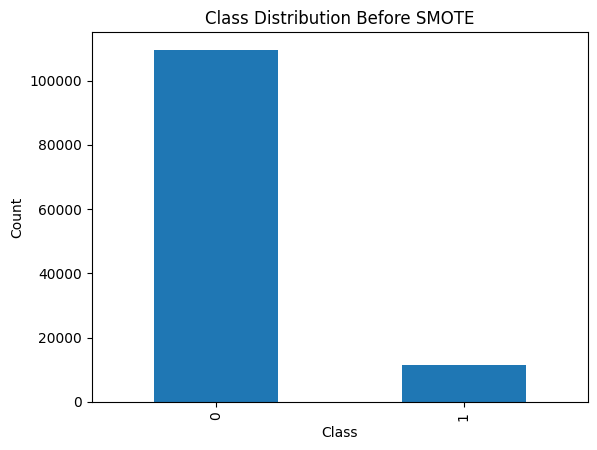

In [41]:
plt.figure()
y_train.value_counts().plot(kind='bar')
plt.title("Class Distribution Before SMOTE")
plt.xlabel("Class")
plt.ylabel("Count")
plt.show()


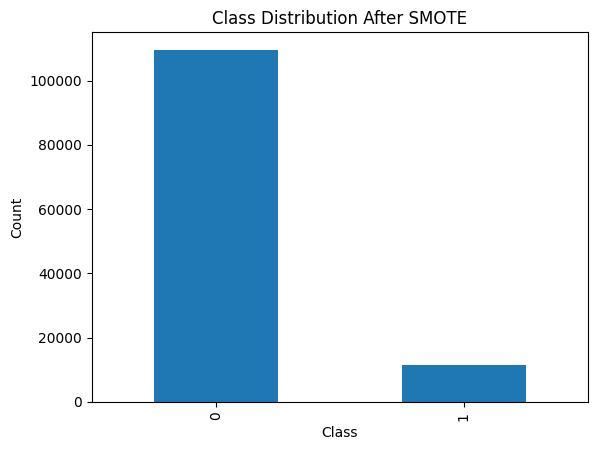

In [43]:
plt.figure()
y_train.value_counts().plot(kind='bar')
plt.title("Class Distribution After SMOTE")
plt.xlabel("Class")
plt.ylabel("Count")
plt.show()


In [35]:
from imblearn.over_sampling import SMOTE

print("Before SMOTE:")
print(y_train.value_counts())

smote = SMOTE(sampling_strategy=0.3, random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

print("\nAfter SMOTE:")
print(y_train_resampled.value_counts())


Before SMOTE:
class
0    109568
1     11321
Name: count, dtype: int64

After SMOTE:
class
0    109568
1     32870
Name: count, dtype: int64


In [37]:
X_train_resampled.to_csv("../data/processed/X_train.csv", index=False)
y_train_resampled.to_csv("../data/processed/y_train.csv", index=False)
X_test.to_csv("../data/processed/X_test.csv", index=False)
y_test.to_csv("../data/processed/y_test.csv", index=False)
